In [1]:
pip install imutils

You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
%matplotlib inline

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(fp_list, notfp_list):
    data_dict = {}
    data_dict["n_fps"] = len(fp_list)
    data_dict["n_notfps"] = len(notfp_list)
    fp_img = mpimg.imread(fp_list[0])
    data_dict["image_shape"] = fp_img.shape
    data_dict["data_type"] = fp_img.dtype
    return data_dict

In [4]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [5]:
import glob

#Read fps and not-fps images

#Data folders
fishplate_dir =     'C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/'
non_fishplate_dir = 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/neg/'

# images are divided up into fishplate and non-fishplate
fps = []
notfps = []

# Read fishplate images
images = glob.iglob(fishplate_dir + '*.jpg', recursive=True)
for image in images:
        fps.append(image)
        
# Read non-fishplate images
images = glob.iglob(non_fishplate_dir + '*.jpg', recursive=True)
for image in images:
        notfps.append(image)
    
data_info = data_look(fps, notfps)

print('Your function returned a count of', 
      data_info["n_fps"], 'fps and', 
      data_info["n_notfps"], 'nonfps')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 40 fps and 40 nonfps
of size:  (100, 100, 3)  and data type: uint8


Example fp images


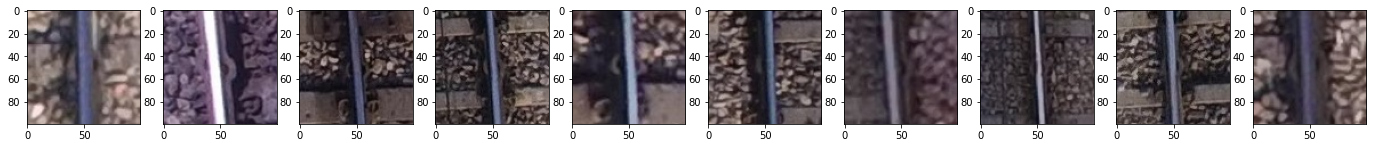

Example not-fp images


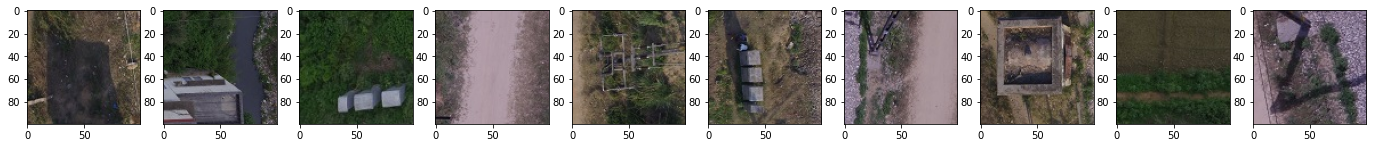

In [6]:
#Visualize some input images
import random

num_images = 10

# Just for fun choose random fp / not-fp indices and plot example images   
fps_samples = random.sample(list(fps), num_images)
notfp_samples = random.sample(list(notfps), num_images)
    
# Read in fp / not-fp images
fp_images = []
notfp_images = []
for sample in fps_samples:
    fp_images.append(mpimg.imread(sample))
    
for sample in notfp_samples:
    notfp_images.append(mpimg.imread(sample))

visualize_images(fp_images, num_images, "Example fp images")
visualize_images(notfp_images, num_images, "Example not-fp images")

Text(0.5, 1.0, 'YUV')

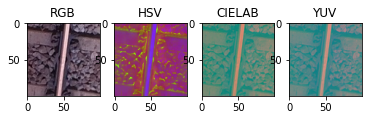

In [7]:
# # Plot the examples
img = cv2.imread('C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/40.jpg')
plt.subplot(141)
plt.imshow(img)
plt.title('RGB')
plt.subplot(142)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
plt.imshow(hsv) 
plt.title('HSV')
plt.subplot(143)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
plt.imshow(lab)
plt.title('CIELAB')
plt.subplot(144)
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
plt.imshow(yuv) 
plt.title('YUV')

In [8]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Text(0.5, 1.0, 'not fp HOG')

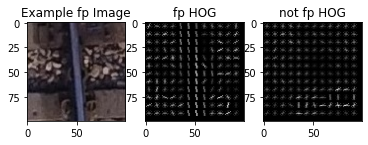

In [9]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

fp_features, hog_image = get_hog_features(cv2.cvtColor(fp_images[1], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

notfp_features, notfp_hog_image = get_hog_features(cv2.cvtColor(notfp_images[2], cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(131)
plt.imshow(fp_images[2])
plt.title('Example fp Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('fp HOG')
plt.subplot(133)
plt.imshow(notfp_hog_image, cmap='gray')
plt.title('not fp HOG')

In [10]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [11]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=16, orient=16, 
                        pix_per_cell=16, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)   

            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [13]:
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16
pix_per_cell = 16
cell_per_block = 2
hog_channel =0 # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=16

t=time.time()

fp_features = extract_features(fps, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_bins=hist_bins)
notfp_features = extract_features(notfps, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((fp_features, notfp_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(fp_features)), np.zeros(len(notfp_features))))

print(len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 30)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

0.97 Seconds to extract HOG features...
(80, 7920)
80
Using: 16 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 7920
0.03 Seconds to train SVC...


In [14]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 6))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  1.0
My SVC predicts:  [1. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
For these 10 labels:  [1. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
0.00299 Seconds to predict 10 labels with SVC


In [15]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=16, hist_range=(0, 256),
                        orient=16,pix_per_cell=16, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    for img in imgs:
        image_orig= cv2.imread(img)
        images=[image_orig]
        image_flipped= cv2.flip(image_orig,1)
        images.append(image_flipped)

            
        for image in images:
            feature_image=None
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image) 
            image_feature=[]
            if spatial_feat==True:
                image_feature= image_features(feature_image, color_space, spatial_size) 

            histogram_features=[]
            if hist_feat==True:
                histogram_features= color_hist(feature_image, hist_bins, hist_range)

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
    #         print(hog_features[0])
    #         features.append(hog_features)
            features.append(np.concatenate((image_feature, histogram_features,hog_features)))

       
    return features

In [16]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=16, orient=16, 
                        pix_per_cell=16, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
#         print(feature_image)
        
        spatial_features = image_features(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
       
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [17]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), offset=0):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = (img.shape[0]//2)+offset #(img.shape[0]*2//3)+20
#         print((img.shape[0]//2)-100)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    window_list = []

    
    scales=[1,1,1.5,1.5]
    ystart=y_start_stop[0]
    for scale in scales:
        over_x= xy_overlap[0]
        over_y= xy_overlap[1]
        width= xy_window[0]*scale
        height= xy_window[1]*scale
        c= y_start_stop[0]
        
        for row in range(2):
            col=0
            endx=0
            image_width= img.shape[1]
            
            while(endx<image_width):
                
                startx = x_start_stop[0]+ col*width*(1-over_x)
                endx = startx + width
                starty = ystart+ row*height*(1-over_y)
                endy = starty + height
                if(endx-startx==endy-starty and endx-startx!=0):
#                     print(endx-startx, endy-starty)
                    window_list.append(((int(startx), int(starty)), (int(endx), int(endy)), width/64.0))
                col+=1
#         y_start_stop[0]-=5    
    return window_list

In [18]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 500] # Min and max in y to search in slide_window()

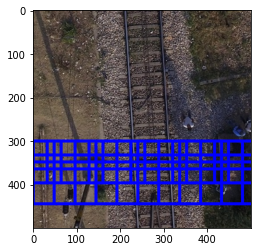

In [19]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_image = 'C:/Users/hp/Desktop/Mod1-IITR/test/3.JPG'
feature_image = cv2.imread(test_image)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
plt.imshow(feature_image)
windows = slide_window(feature_image, x_start_stop=[None, None], y_start_stop=y_start_stop)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

In [20]:
#using HOG , division of features and then putting SVM
#from train.py, windows.py, features.py
import numpy as np
import cv2
from skimage.feature import hog
import pickle
import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.neighbors import KNeighborsClassifier
from skimage import exposure
from skimage import feature
from imutils import paths
import argparse
import imutils
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC# "Support Vector Classifier"
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

In [21]:
#the following code is for finding HOG using code #1  : features.py
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False,transform_sqrt=True, feature_vec=True):
	if vis == True:
		features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
			cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
			visualize=True, feature_vector=False)
		return features, hog_image
	else:
		features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
			cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
			visualize=False, feature_vector=feature_vec)
		return features

In [22]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
					xy_window=(100,84), xy_overlap=(0.5, 0.5)):

	if x_start_stop[0] == None:
		x_start_stop[0] = 0
	if x_start_stop[1] == None:
		x_start_stop[1] = img.shape[1]
	if y_start_stop[0] == None:
		y_start_stop[0] = 0
	if y_start_stop[1] == None:
		y_start_stop[1] = img.shape[0]
	# Compute the span of the region to be searched
	xspan = x_start_stop[1] - x_start_stop[0]
	yspan = y_start_stop[1] - y_start_stop[0]
	# Compute the number of pixels per step in x/y
	nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
	ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
	# Compute the number of windows in x/y
	nx_windows = np.int(xspan/nx_pix_per_step) - 1
	ny_windows = np.int(yspan/ny_pix_per_step) - 1
	# Initialize a list to append window positions to
	window_list = []

	for ys in range(ny_windows):
		for xs in range(nx_windows):
			# Calculate window position
			startx = xs*nx_pix_per_step + x_start_stop[0]
			endx = startx + xy_window[0]
			starty = ys*ny_pix_per_step + y_start_stop[0]
			endy = starty + xy_window[1]

			# Append window position to list
			window_list.append(((startx, starty), (endx, endy)))
	# Return the list of windows
	return window_list

In [23]:
def search_windowfeature(image2,color_space='RGB',orient=16,pix_per_cell=16, cell_per_block=2):       

        test_img = cv2.cvtColor(window,cv2.COLOR_RGB2GRAY)    
        hogfeaturestest, hog_imagetest = get_hog_features(test_img, orient,pix_per_cell, cell_per_block,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresizetest=hogfeaturestest.size
        hogfeaturestest=np.reshape(hogfeaturestest,(featuresizetest,),order='C')
        hogfeaturestest= hogfeaturestest.reshape(1,-1)	# THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        return hogfeaturestest    


In [24]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
	# Make a copy of the image
	imcopy = np.copy(img)
	# Iterate through the bounding boxes
	for bbox in bboxes:
		# Draw a rectangle given bbox coordinates
		cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
	# Return the image copy with boxes drawn
	return imcopy

In [25]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [26]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 500] # Min and max in y to search in slide_window()

In [27]:
if __name__ == '__main__':
    posfeatures=[]
    h1=[]
    positive= 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/pos/'
    for image_file in os.listdir(positive):
        image = mpimg.imread(os.path.join(positive,image_file))

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray=np.resize(gray,(100,84))
        
#    one method for finding hog............. !!
        hogfeatures, hog_image = get_hog_features(gray, orient=9,pix_per_cell=16, cell_per_block=2,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresize=hogfeatures.size
        hogfeatures=np.reshape(hogfeatures,(featuresize,),order='C')
        hogfeatures= hogfeatures.reshape(1,-1)
        posfeatures.append(hogfeatures)
        tpos=np.concatenate(posfeatures)  
        h1.append(np.concatenate(posfeatures))

#for negative examples
    negfeatures=[]
    h2=[]
    negative= 'C:/Users/hp/Desktop/Mod1-IITR/fishplate/neg/'
    for image_file1 in os.listdir(negative):
        image1 = mpimg.imread(os.path.join(negative,image_file1))

        gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        gray1=np.resize(gray1,(100,84))
        
#    one method for finding hog............. !!
        hogfeatures1, hog_image1 = get_hog_features(gray1, orient=9,pix_per_cell=16, cell_per_block=2,vis=True,transform_sqrt=True,feature_vec=True,)
        featuresize1=hogfeatures1.size
        hogfeatures1=np.reshape(hogfeatures1,(featuresize1,),order='C')
        hogfeatures1= hogfeatures1.reshape(1,-1)
#        fig = plt.figure()
#        plt.subplot(121)
#        plt.imshow(image)
#        plt.title('Example positive Image')
#        plt.subplot(122)
#        plt.imshow(hog_image, cmap='gray')
#        plt.title('HOG Visualization')
#        plt.show()
        negfeatures.append(hogfeatures1)
#        tpos=get_hogfeaturesmain(positive)
        t=np.concatenate(negfeatures)  
        h2.append(np.concatenate(negfeatures))
    
#SVM classification 
svc = LinearSVC()
X_scaler = StandardScaler() 
#train1(tpos,t,svc,X_scaler)
#"""
X = np.vstack((tpos,t))
	# Fit a per-column scaler
X_scaler.fit(X)
	# Apply the scaler to X
scaled_X = X_scaler.transform(X)

	# Define the labels vector
y = np.hstack((np.ones(len(tpos)), np.zeros(len(t))))
rand_state = np.random.randint(0, 40)
X_train, X_test, y_train, y_test = train_test_split(
		scaled_X, y, test_size=0.20, random_state=rand_state)
    # Check the training time for the SVC
time1=time.time()
svm_model_linear=svc.fit(X_train, y_train)
#svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-time1, 2), 'Seconds to train SVC...')
svm_predictions = svm_model_linear.predict(X_test)
svm_predictions = svc.predict(X_test)
print('Test Accuracy of SVC = ',svm_model_linear.score(X_test, y_test))  


imdir = 'C:/Users/hp/Desktop/Mod1-IITR/test/'
xcord=[]
ycord1=[]
(winW, winH) = (128,128)
for image_file in os.listdir(imdir):
    image2 = mpimg.imread(os.path.join(imdir, image_file))

    on_windows=[]
    #pred=[]
    clone = image2.copy()

    for (x, y, window) in sliding_window(image2, stepSize=32, windowSize=(winW, winH)):  # loop over the sliding window for each layer of the pyramid
        if window.shape[0] != winH or window.shape[1] != winW: # if the window does not meet our desired window size, ignore it
            continue
        #windowstestfeat = search_windowfeature(window,color_space=color_space,orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block)  	# THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        #testfeaturesh = X_scaler.transform(windowstestfeat) 
        #prediction =svm_model_linear.predict(testfeaturesh) 
        #pred.append(prediction)
        #if prediction==1:
        #    on_windows.append(window)
        #    xcord.append(x)
        #    ycord1.append(y) 
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow("Window",clone)
        k=cv2.waitKey(1)
        
        time.sleep(0.025)

0.01 Seconds to train SVC...
Test Accuracy of SVC =  0.75
